In [79]:
import matplotlib.pyplot as plt
import numpy as np

filedir = './data/'
filenames = ['CARAS63 .ELH']
fs = 500                    # частота дискретизации, Гц
first_stim_start_time = 1   # начало первого стимула, с
period = 5                  # период следования стимулов, с
background_start_time = 5   # начало фоновой засветки, с
background_duration = 40    # длительность фоновой засветки, с
sign = 1                    # полярность {1:'+', -1:'-'}
low_cutoff = 0.1            # частота среза highpass фильтра, Гц
# начало первого импульса после фоновой засветки
after_background_start_time = first_stim_start_time + ((background_start_time + background_duration - first_stim_start_time) // period + 1) * period

In [80]:
signal = []
for filename in filenames:
    with open(filedir + filename, 'r', encoding='utf-8') as file:
        file.readline()
        line = file.readline()
        while line and line[0] == '"':
            line = file.readline()
        signal.append(sign * float('0' if line == '.\n' else line))
        for line in file:
            signal.append(sign * float('0' if line == '.\n' else line))
signal = np.array(signal)

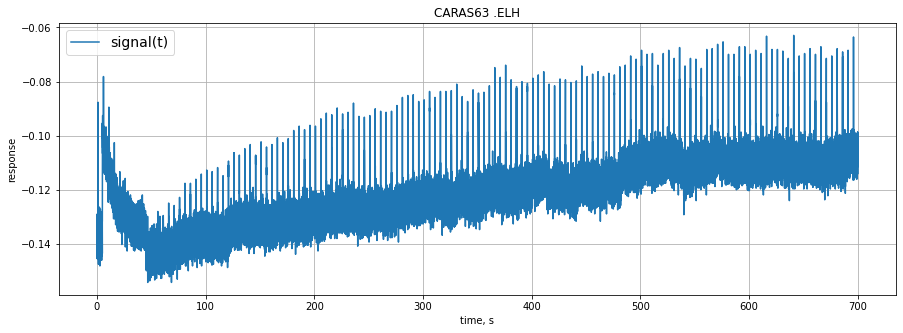

In [81]:
n = signal.size
t = np.linspace(0, (n - 1) / fs, n)
fig, ax = plt.subplots()
ax.plot(t, signal, label='signal(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(','.join(filenames))
ax.legend(prop={"size": 14})
ax.grid()

In [82]:
# Смещение сигнала до начала фона к 0
signal[:background_start_time * fs] -= signal[:first_stim_start_time * fs].mean()

begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
# Копия фона - необходима, чтобы его потом нарисовать вместе с отфильтрованным сигналом
background = np.array(signal[begin:end])
# Смещение сигнала после окончания фона к 0
signal[end:] -= signal[end:after_background_start_time * fs].mean()
# Удаление фона, для того чтобы избежать переходного процесса фильтра после него и измерить высоту первого после него стимула
signal[begin:end] = 0

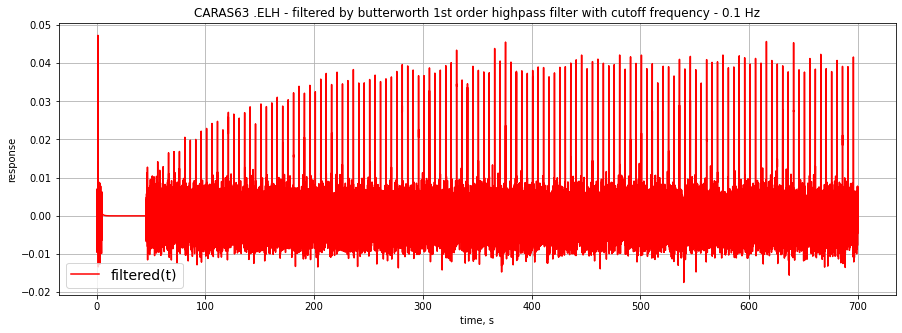

In [83]:
from scipy.signal import butter, lfilter

nyq = 0.5 * fs
b, a = butter(1, low_cutoff / nyq, btype='highpass', analog=False)
filtered = lfilter(b, a, signal)

fig, ax = plt.subplots()
ax.plot(t, filtered, 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - filtered by butterworth 1st order highpass filter with cutoff frequency - {low_cutoff} Hz')
ax.legend(prop={"size": 14})
ax.grid()

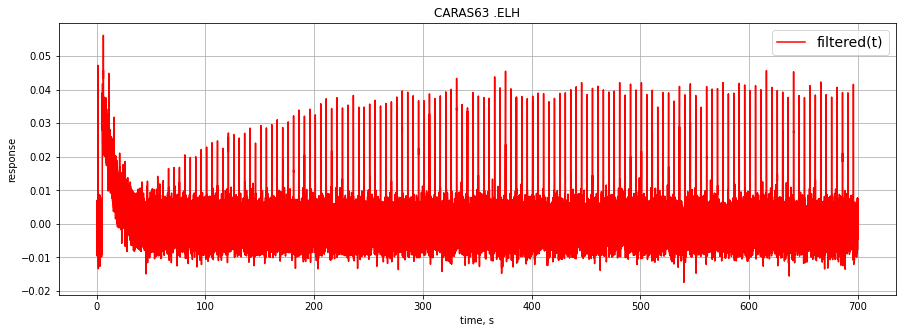

In [84]:
# Возврат ступеньки, смещенной к нулю, в отфильтрованный сигнал, просто чтобы ее нарисовать
begin = background_start_time * fs
end = after_background_start_time * fs - (after_background_start_time - background_start_time - background_duration) * fs // 2
filtered[begin:end] = background - background[0]


fig, ax = plt.subplots()
ax.plot(t, filtered, 'r', label='filtered(t)')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)}')
ax.legend(prop={"size": 14})
ax.grid()

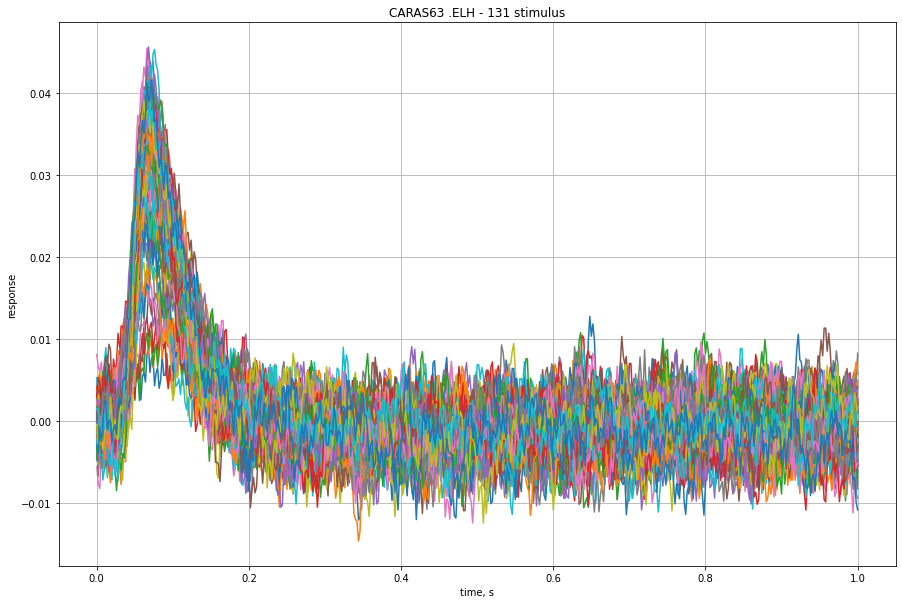

In [85]:
stims_cnt = ((n - 1) // fs - after_background_start_time) // period + 1
stims = []
for i in range(stims_cnt):
    begin = (after_background_start_time + period * i) * fs
    end = begin + fs
    stims.append(filtered[begin:end + 1])
temp_t = np.linspace(0, 1, fs + 1)
fig, ax = plt.subplots()
for stim in stims:
    ax.plot(temp_t, stim)
fig.set_figwidth(15)
fig.set_figheight(10)
ax.set_xlabel('time, s')
ax.set_ylabel('response')
ax.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus')
ax.grid()

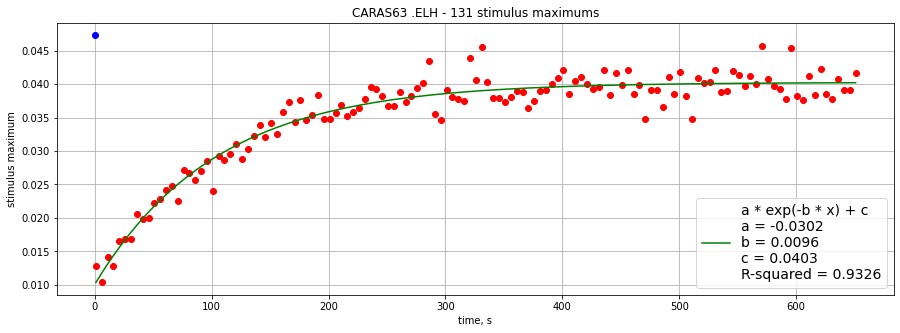

In [86]:
from scipy import stats, optimize

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

stim_maximums = np.array([stim.max() for stim in stims])
# Начало графика максимумов стимулов располагается от 0 на расстоянии между началом первого импульса после фоновой засветки и ее концом
begin = after_background_start_time - background_start_time - background_duration
end = begin + (stims_cnt - 1) * period
stim_maximums_x = np.linspace(begin, end, stims_cnt)
popt, pcov = optimize.curve_fit(func, stim_maximums_x, stim_maximums, [-0.05, 0.01, 0.05])
exp_a = popt[0]
exp_b = popt[1]
exp_c = popt[2]
fit = func(stim_maximums_x, *popt)
rvalue = stats.linregress(stim_maximums, fit).rvalue
r_squared = rvalue ** 2

fig, ax = plt.subplots()
ax.plot(stim_maximums_x, stim_maximums, 'ro')
begin = first_stim_start_time * fs
end = begin + fs

#Максимум опорного стимула смещается из точки first_stim_start_time в точку 0.
first_stim_max = filtered[begin: end].max()
ax.plot(0, first_stim_max, 'bo')
ax.plot(stim_maximums_x, fit, 'g', label=f'a * exp(-b * x) + c\n'
                           f'a = {exp_a:.4f}\n'
                           f'b = {exp_b:.4f}\n'
                           f'c = {exp_c:.4f}\n'
                           f'R-squared = {r_squared:.4f}')
fig.set_figwidth(15)
fig.set_figheight(5)
ax.set_xlabel('time, s')
ax.set_ylabel('stimulus maximum')
ax.set_title(f'{",".join(filenames)} - {stims_cnt} stimulus maximums')
ax.legend(prop={"size": 14})
ax.grid()

In [87]:
with open(f'./output/{",".join(filenames)}.txt', 'w', encoding='utf-8') as file:
    file.write(f'Файл(ы)\t{",".join(filenames)}\n')
    file.write(f'Длительность фона, c\t{background_duration}\n')
    file.write(f'Период следования стимулов, с\t{period}\n')
    file.write(f'Длительность записи, с\t{(n - 1) / fs}\n')
    file.write(f'Частота дискретизации, Гц\t{fs}\n')
    file.write(f'Параметр экспоненты a\t{exp_a:.4f}\n')
    file.write(f'Параметр экспоненты b\t{exp_b:.4f}\n')
    file.write(f'Параметр экспоненты c\t{exp_c:.4f}\n')
    file.write(f'Постоянная времени 1/b\t{1 / exp_b:.4f}\n')
    file.write(f'R-squared\t{r_squared:.4f}\n')

    file.write('\n')
    file.write('time, с\tU, у.е\tфункция аппроксимации (a * exp(-b * x) + c)\n')
    file.write(f'{0}\t{first_stim_max}\n')
    for i in range(stim_maximums.size):
        file.write(f'{stim_maximums_x[i]}\t{stim_maximums[i]}\t{fit[i]}\n')